# 这个用于检验各种特征转换的效果，统一采用LGB模型，并进行五折交叉验证

## Loading the library

In [28]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import QuantileTransformer,MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

## Loading the DataSet

In [2]:
train_df = pd.read_csv("../SantanderData/train.csv")
test_df = pd.read_csv("../SantanderData/test.csv")

## Getting the raw feature and target

In [3]:
features = train_df.columns.values[2:]
train_X = train_df[features].values
train_Y = train_df['target'].values
test_X = test_df[features].values

## Setting the function of transform

In [6]:
def feature_transform(train_X,test_X,transform_type):
    transformer = {'QT':QuantileTransformer(),'MM':MinMaxScaler(),'SS':StandardScaler()}
    t_train_X = transformer[transform_type].fit_transform(train_X)
    t_test_X = transformer[transform_type].fit_transform(test_X)
    return t_train_X,t_test_X

## Setting the model and params

In [17]:
params = {
        'num_leaves': 10,
        'max_bin': 119,
        'min_data_in_leaf': 11,
        'learning_rate': 0.02,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0,
        'bagging_freq': 5,
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
}

In [37]:
def model(train_X,train_Y,test_X,params,features,transform_type,nfold = 5):
        skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2019)
        oof = np.zeros(len(train_X))
        predictions = np.zeros(len(test_X))
        feature_importance_df = pd.DataFrame()
        i = 1
        for train_index, valid_index in skf.split(train_X, train_Y):
            print("\nfold {}".format(i))

            xg_train = lgb.Dataset(train_X[train_index, :],
                                   label=train_Y[train_index],
                                   free_raw_data=False
                                   )
            xg_valid = lgb.Dataset(train_X[valid_index, :],
                                   label=train_Y[valid_index],
                                   free_raw_data=False
                                   )
            evals_result = {} #record the result for metric plotting
            clf = lgb.train(params, xg_train, 15000, valid_sets=[xg_train,xg_valid], verbose_eval=1000, early_stopping_rounds=250,evals_result=evals_result)
            plt.figure(figsize=(12, 6))
            lgb.plot_metric(evals_result, metric='auc')
            plt.title("Metric")
            plt.savefig("figure/Metric{:}{:}.png".format(i,transform_type))
            oof[valid_index] = clf.predict(train_X[valid_index, :], num_iteration=clf.best_iteration)
            #print("fold{:}'s roc is: {:<0.5f}".format(i,roc_auc_score(oof[valid_index],self.train_Y[valid_index])))
            fold_importance_df = pd.DataFrame()
            fold_importance_df["Feature"] = features
            fold_importance_df["importance"] = clf.feature_importance()
            fold_importance_df["fold"] = i
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            predictions += clf.predict(test_X, num_iteration=clf.best_iteration) / nfold
            i = i + 1
        CVScore = roc_auc_score(train_Y, oof)
        return CVScore,feature_importance_df,predictions

## Plotting the feature importance

In [38]:
def feature_barplot(feature_importance_df,transform_type):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[0:150].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    plt.figure(figsize=(14, 28))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.savefig('figure/FI{:}.png'.format(transform_type))

## Start training

begin the  QT

fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904056	valid_1's auc: 0.885605
[2000]	training's auc: 0.920108	valid_1's auc: 0.894137
[3000]	training's auc: 0.9303	valid_1's auc: 0.898103
[4000]	training's auc: 0.937753	valid_1's auc: 0.899313
[5000]	training's auc: 0.944336	valid_1's auc: 0.899666
Early stopping, best iteration is:
[5536]	training's auc: 0.947693	valid_1's auc: 0.899821

fold 2
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904482	valid_1's auc: 0.881457
[2000]	training's auc: 0.92033	valid_1's auc: 0.890411
[3000]	training's auc: 0.930413	valid_1's auc: 0.894727
[4000]	training's auc: 0.937956	valid_1's auc: 0.89653
Early stopping, best iteration is:
[4557]	training's auc: 0.941711	valid_1's auc: 0.896875

fold 3
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.90371	valid_1's auc: 0.886758
[2000]	training's auc: 0.919896	vali

C:\Users\18351\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


begin the  MM

fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904059	valid_1's auc: 0.885505
[2000]	training's auc: 0.920116	valid_1's auc: 0.894025
[3000]	training's auc: 0.930321	valid_1's auc: 0.898013
[4000]	training's auc: 0.937791	valid_1's auc: 0.899229
[5000]	training's auc: 0.944336	valid_1's auc: 0.89963
Early stopping, best iteration is:
[5406]	training's auc: 0.946855	valid_1's auc: 0.899736

fold 2
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904473	valid_1's auc: 0.881565
[2000]	training's auc: 0.920387	valid_1's auc: 0.89083
[3000]	training's auc: 0.930472	valid_1's auc: 0.895061
[4000]	training's auc: 0.938	valid_1's auc: 0.896866
[5000]	training's auc: 0.94463	valid_1's auc: 0.897508
Early stopping, best iteration is:
[5002]	training's auc: 0.944643	valid_1's auc: 0.897516

fold 3
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.903883	valid

C:\Users\18351\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


final CV:0.89823


C:\Users\18351\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\18351\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


begin the  SS

fold 1
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904417	valid_1's auc: 0.885674
[2000]	training's auc: 0.920217	valid_1's auc: 0.89429
[3000]	training's auc: 0.930407	valid_1's auc: 0.897863
[4000]	training's auc: 0.937953	valid_1's auc: 0.899161
[5000]	training's auc: 0.944558	valid_1's auc: 0.899594
[6000]	training's auc: 0.950673	valid_1's auc: 0.899711
Early stopping, best iteration is:
[5797]	training's auc: 0.949491	valid_1's auc: 0.899774


C:\Users\18351\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



fold 2
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904401	valid_1's auc: 0.881639
[2000]	training's auc: 0.920415	valid_1's auc: 0.89061
[3000]	training's auc: 0.930394	valid_1's auc: 0.895021
[4000]	training's auc: 0.937922	valid_1's auc: 0.897005
[5000]	training's auc: 0.944532	valid_1's auc: 0.89756
Early stopping, best iteration is:
[5053]	training's auc: 0.94487	valid_1's auc: 0.897605

fold 3
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.904001	valid_1's auc: 0.886356
[2000]	training's auc: 0.919976	valid_1's auc: 0.89469
[3000]	training's auc: 0.930269	valid_1's auc: 0.898554
[4000]	training's auc: 0.937743	valid_1's auc: 0.900117
[5000]	training's auc: 0.944408	valid_1's auc: 0.900564
Early stopping, best iteration is:
[5321]	training's auc: 0.946456	valid_1's auc: 0.900663

fold 4
Training until validation scores don't improve for 250 rounds.
[1000]	training's auc: 0.905023	valid_1's auc: 0.

C:\Users\18351\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\Users\18351\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x432 with 0 Axes>

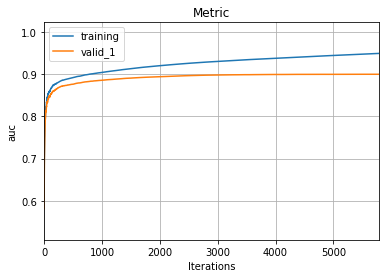

<Figure size 864x432 with 0 Axes>

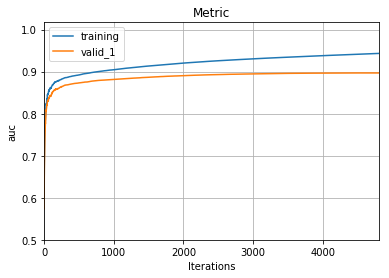

<Figure size 864x432 with 0 Axes>

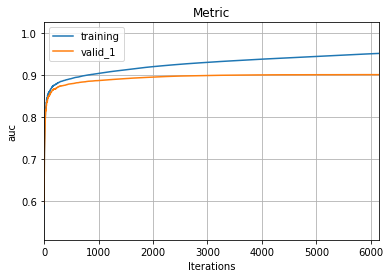

<Figure size 864x432 with 0 Axes>

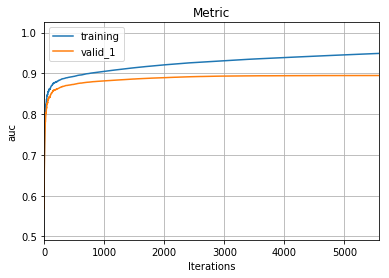

<Figure size 864x432 with 0 Axes>

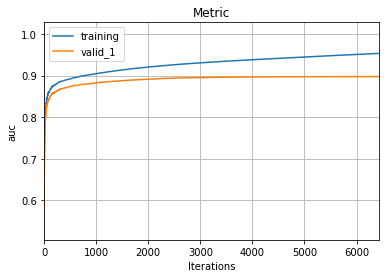

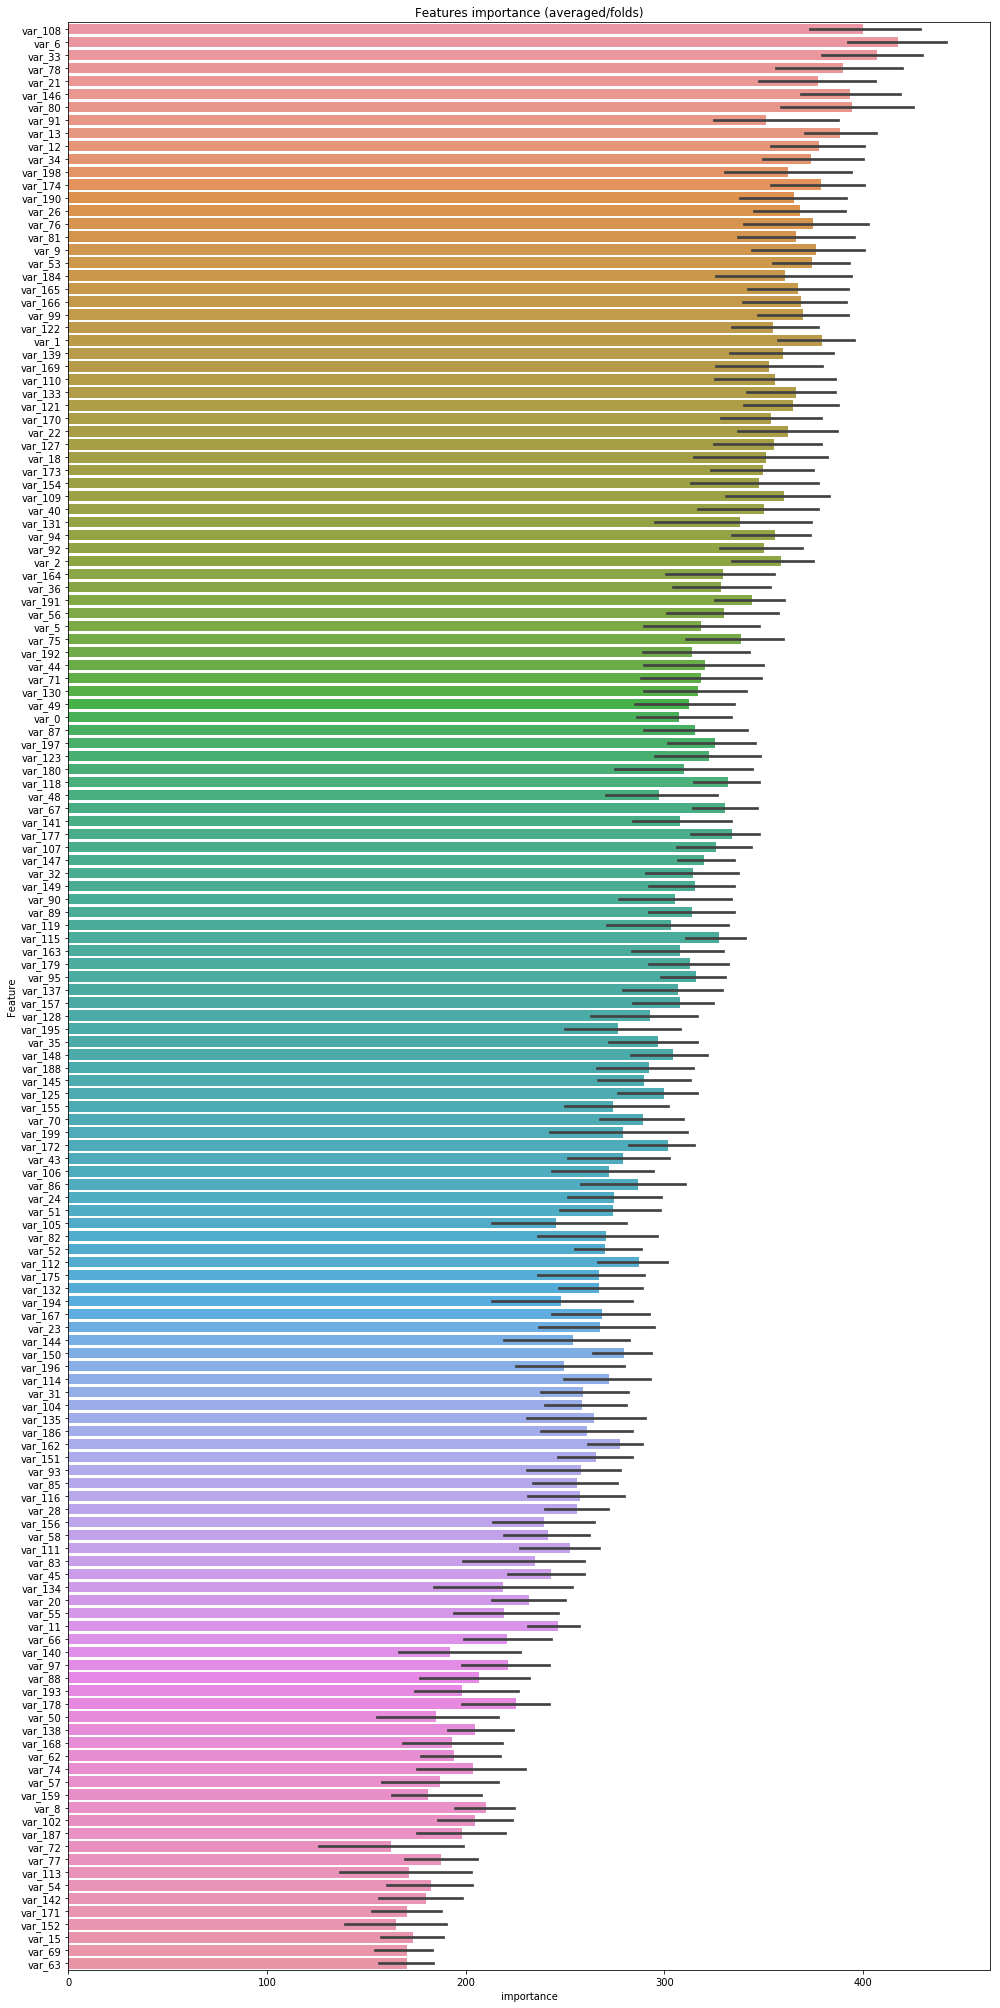

<Figure size 864x432 with 0 Axes>

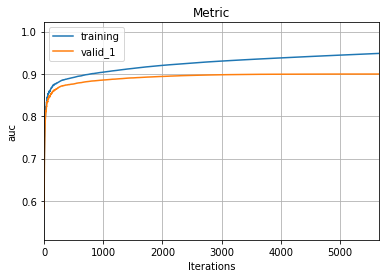

<Figure size 864x432 with 0 Axes>

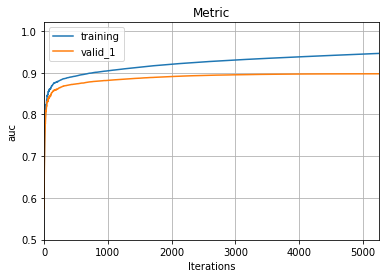

<Figure size 864x432 with 0 Axes>

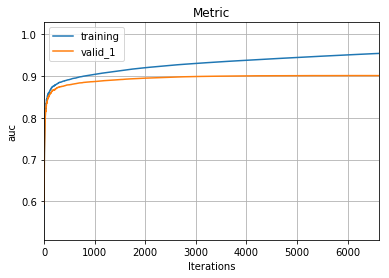

<Figure size 864x432 with 0 Axes>

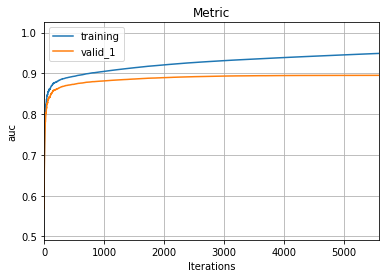

<Figure size 864x432 with 0 Axes>

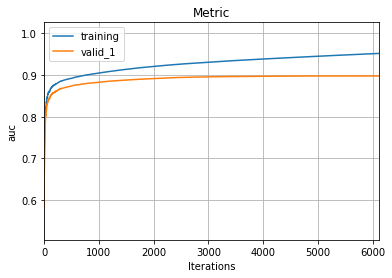

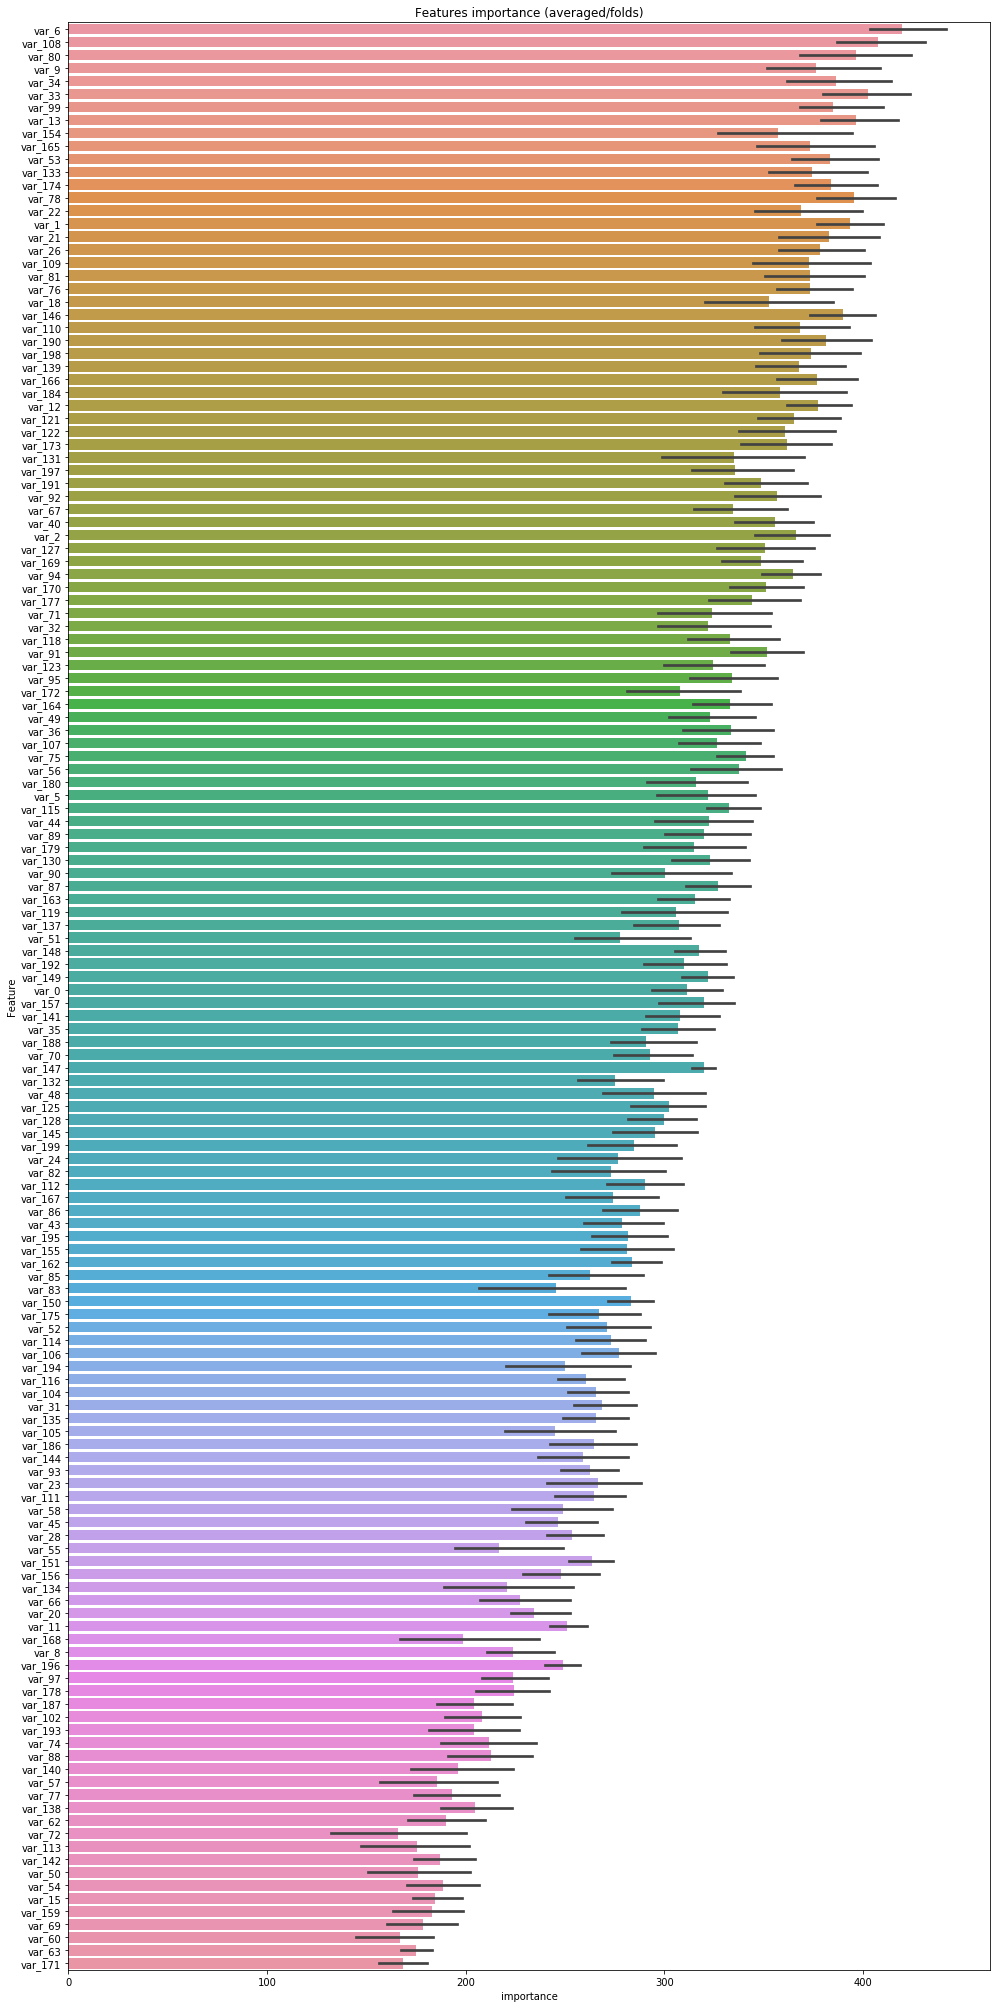

<Figure size 864x432 with 0 Axes>

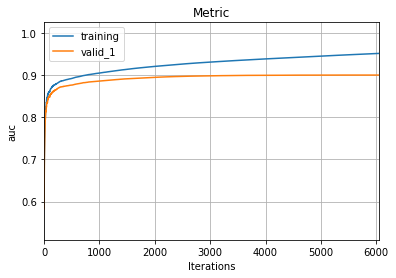

<Figure size 864x432 with 0 Axes>

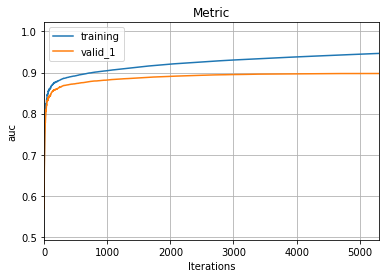

<Figure size 864x432 with 0 Axes>

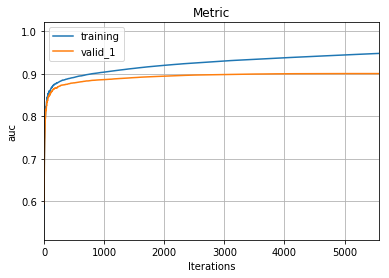

<Figure size 864x432 with 0 Axes>

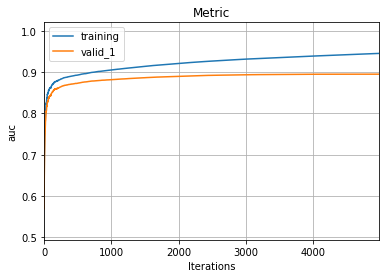

<Figure size 864x432 with 0 Axes>

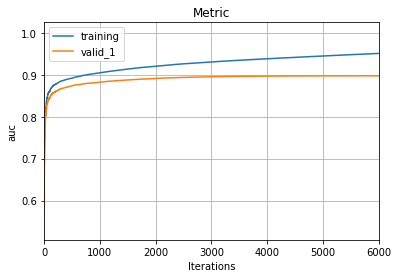

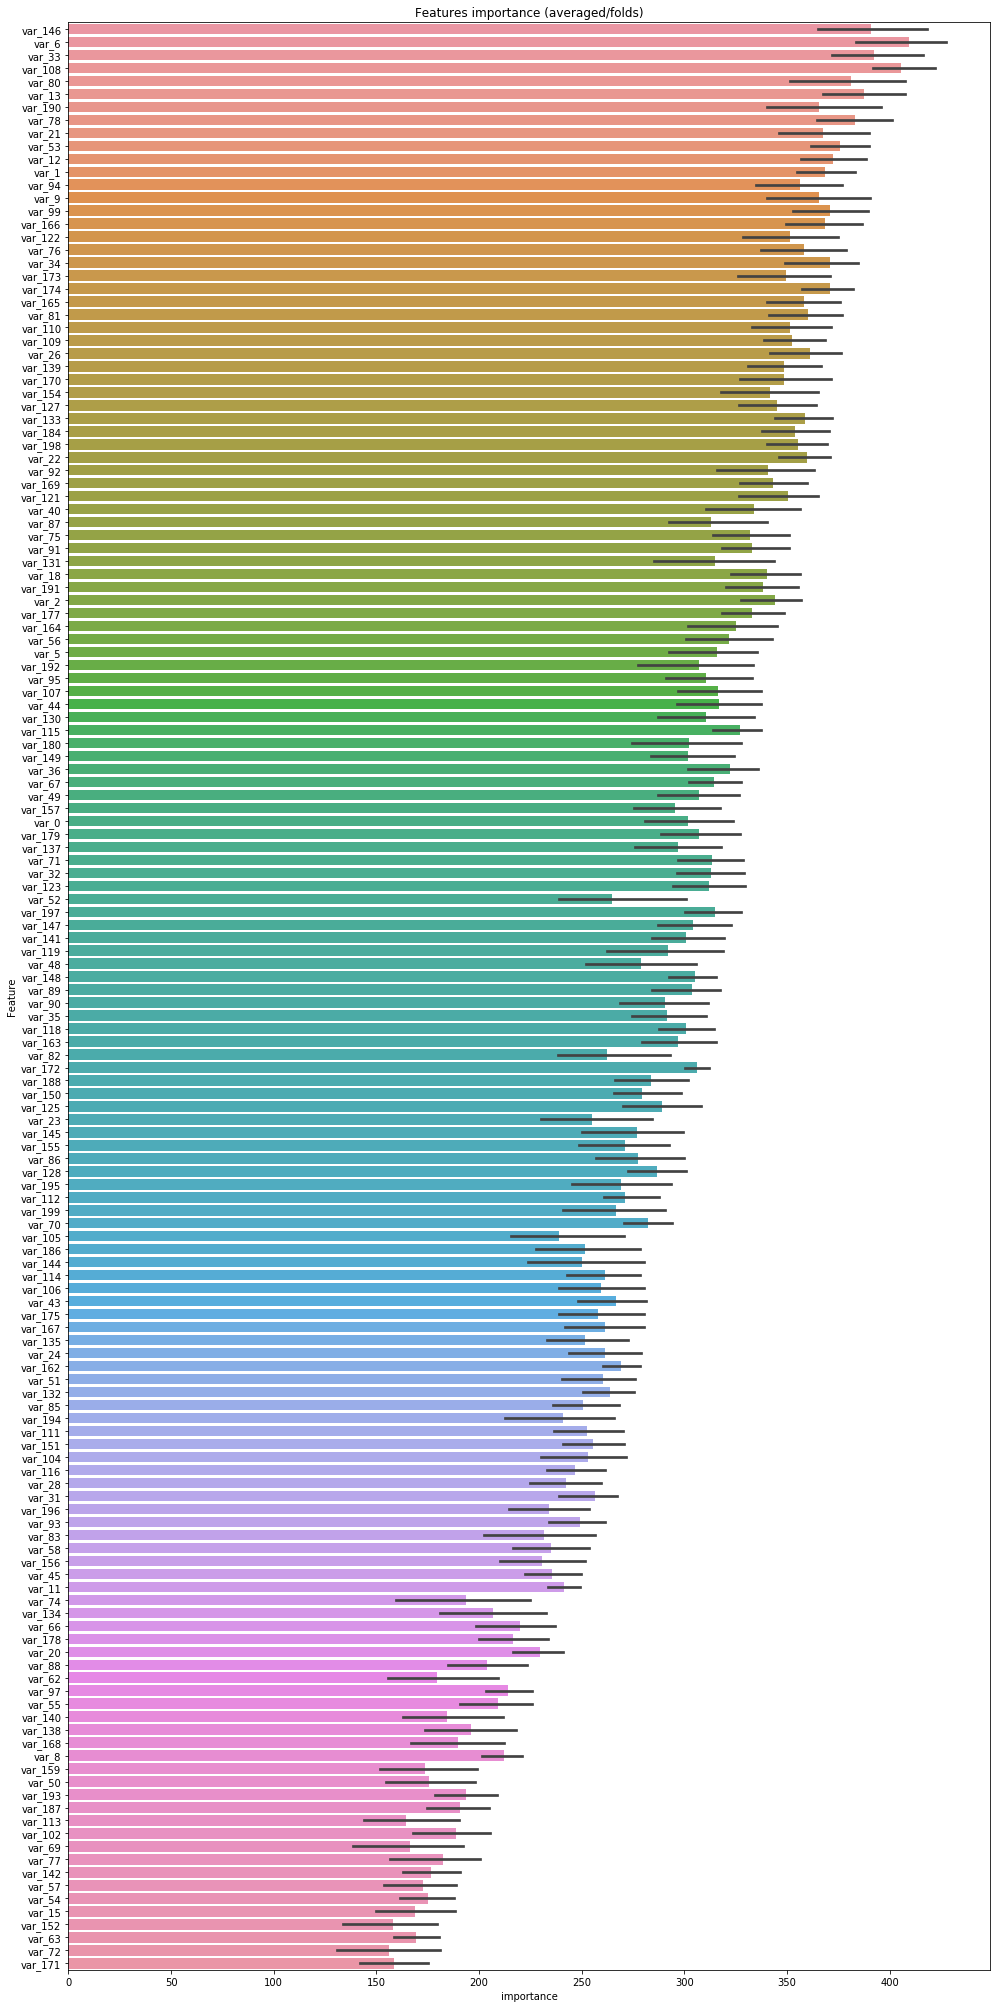

In [39]:
for transform_type in ['MM']:
    print("begin the ",transform_type)
    tr_X,te_X = feature_transform(train_X,test_X,transform_type)
    CVScore,feature_importance_df,predictions = model(tr_X,train_Y,te_X,params,features,transform_type)
    print("final CV:{:<0.5f}".format(CVScore))
    feature_barplot(feature_importance_df,transform_type)
    sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
    sub_df["target"] = predictions
    sub_df.to_csv("../SantanderData/submission_{:}.csv".format(transform_type), index=False)

In [50]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 100,verbose = -1,random_state = 2019,n_jobs = -1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2019)
oof = np.zeros(len(train_X))
predictions = np.zeros(len(test_X))
i = 1
for train_index, valid_index in skf.split(train_X, train_Y):
    print("\nfold {}".format(i))
    clf.fit(train_X[train_index,:],train_Y[train_index])
    oof[valid_index] = clf.predict_proba(train_X[valid_index,:])[:,1]
    predictions += clf.predict_proba(test_X)[:,1]/5
    i = i+1
oof[oof >= 0.5] = 1
oof[oof< 0.5] = 0
CVScore = roc_auc_score(oof,train_Y)
print("CV Score",CVScore)


fold 1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.7s finished



fold 2


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.8s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.9s finished



fold 3


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.9s finished



fold 4


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.7s finished



fold 5


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    0.9s


CV Score 0.9497707419759692


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.9s finished


In [51]:
sub_df = pd.DataFrame({"ID_code":test_df["ID_code"].values})
sub_df["target"] = predictions
sub_df.to_csv("../SantanderData/submission_{:}.csv".format('random_forest'), index=False)